# 2013_spiking_parallel

与串行不同的是，并行的时候是对con的dynamics进行控制

In [14]:
from brian2 import *
%matplotlib inline
import numpy as np

In [ ]:
import brian2genn
set_device('genn')

# parameter

In [2]:
k=200
NE=4*k
NI=1*k
NO=5*k


########time constant#######
#for each neuron
TE=20*ms
TI=10*ms


#for synaptic variable(including NMDA and AMPA)
TEI=TII=5*ms
TEE_N=150*ms
TEE_A=50*ms
TIE_N=45*ms
TIE_A=20*ms
TEO=100*ms

#proba
rou=0.1
#strength(大小，最终还有正负号) 且用数目和概率做一个scaling
JEE=JIE=10/sqrt(NE*rou)*2
JEI=JII=15/sqrt(NI*rou)*2
JEO=100/sqrt(NO*rou)
#strength test(not balanced)
# JEE=100/sqrt(NE*rou)
# JIE=200/sqrt(NE*rou)
# JEI=200/sqrt(NI*rou)
# JII=100/sqrt(NI*rou)
# JEO=100/sqrt(NO*rou)



#proportion of NMDA and AMPA
q_EE_N=0.5
q_EE_A=0.5
q_IE_N=0.2
q_IE_A=0.8

# create neurons and populations

In [3]:
eqs='''
dv/dt=(-v+J_E*(q*con_E_N+(1-q)*con_E_A)-J_I*con_I+J_O*con_O)/tau_neuron:1 (unless refractory)
dcon_E_N/dt = -con_E_N/tau_E_N :1 
dcon_E_A/dt = -con_E_A/tau_E_A :1 
dcon_I/dt = -con_I/tau_I :1
dcon_O/dt = -con_O/tau_O :1
q:1
J_E:1
J_I:1
J_O:1
tau_E_A:second
tau_E_N:second
tau_I:second
tau_O:second
tau_neuron:second
'''
#define all neurons in one group
G=NeuronGroup(NE+NI,eqs,threshold="v>1",reset="v=0",refractory=2*ms, method='exact')

G_E=G[:int(NE)]
G_I=G[int(NE):]

#parameters:
G.tau_neuron[0:int(NE)] = TE
G.tau_neuron[int(NE):] = TI
G.tau_E_N[0:int(NE)] = TEE_N
G.tau_E_N[int(NE):] = TIE_N
G.tau_E_A[0:int(NE)] = TEE_A
G.tau_E_A[int(NE):] = TIE_A
G.tau_I[0:int(NE)] = TEI
G.tau_I[int(NE):] = TII
G.tau_O[0:int(NE)] = TEO
G.tau_O[int(NE):] = 1*ms #这里随意，反正I的con_O一直是0
G.q[0:int(NE)] = q_EE_N
G.q[int(NE):] = q_IE_N
G.J_E[0:int(NE)] = JEE
G.J_E[int(NE):] = JIE
G.J_I[0:int(NE)] = JEI
G.J_I[int(NE):] = JII
G.J_O[0:int(NE)] = JEO
G.J_O[int(NE):] = 0
#Initial values:
G.v[:]=[uniform(0,1) for i in range(NI+NE)]




# Synapses

In [4]:

#equations for synapses from inhibitory neurons
eqs_I='''
w:1
'''
#equations for synapses from inhibitory neurons
#q是N的含量
eqs_E='''
w_N:1
w_A:1
'''


syn_EI=Synapses(G_I,G_E,eqs_I,on_pre="con_I_post+=w",method="exact")
syn_II=Synapses(G_I,G_I,eqs_I,on_pre="con_I_post+=w",method="exact")
syn_IE=Synapses(G_E,G_I,eqs_E,on_pre='''con_E_N+=w_N
con_E_A+=w_A''',method="exact")
syn_EE=Synapses(G_E,G_E,eqs_E,on_pre='''con_E_N+=w_N
con_E_A+=w_A''',method="exact")

#
syn_EI.connect(p=rou)
syn_II.connect(p=rou)
syn_IE.connect(p=rou)
syn_EE.connect(p=rou)

#注意：这里可能需要用N*P进行scale一下...不用scale!不能scale!(之前的con就是sum了)
syn_EI.w=1/(TEI/ms)
syn_II.w=1/(TII/ms)
syn_IE.w_N=1/(TIE_N/ms)
syn_IE.w_A=1/(TIE_A/ms)
syn_EE.w_N=1/(TEE_N/ms)
syn_EE.w_A=1/(TEE_A/ms)



net=Network(collect())

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": http://landinghub.visualstudio.com/visual-cpp-build-tools (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [5]:
###External neurons 只是连接到E上面###
P=PoissonGroup(NO,rates=40*Hz)  #rates= 40Hz
#External input synapses:在simulation的时候加，一开始没有，然后加上去，然后再去掉external input
eqs_O='''
w:1
'''
syn_OE=Synapses(P,G_E,eqs_O,on_pre="con_O+=w",method="exact")
syn_OE.connect(p=rou)
#
# syn_OE.J=JEO
syn_OE.w=1/(TEO/ms)
# syn_OE.tau=TEO 

# Simulation

In [6]:
statemon_G = StateMonitor(G, 'v', record=True)
net.add(statemon_G)
spikemon_G=SpikeMonitor(G)
net.add(spikemon_G) 
#rate
ratemon_E = PopulationRateMonitor(G_E)
net.add(ratemon_E)
ratemon_I = PopulationRateMonitor(G_I)
net.add(ratemon_I)
ratemon_G = PopulationRateMonitor(G)
net.add(ratemon_G)
###for testing
statemon_G_con_I = StateMonitor(G, 'con_I', record=True)
statemon_G_con_E_N = StateMonitor(G, 'con_E_N', record=True)
statemon_G_con_E_A = StateMonitor(G, 'con_E_A', record=True)
statemon_G_con_O = StateMonitor(G, 'con_O', record=True)
net.add(statemon_G_con_I)
net.add(statemon_G_con_O)
net.add(statemon_G_con_E_N)
net.add(statemon_G_con_E_A)

In [7]:
dec_time=100*ms
sti_time=50*ms
mem_time=500*ms


#先让network自己跑一段时间
net.run(dec_time)
#再加入external input
net.add(P)
net.add(syn_OE)
net.run(sti_time)
#再去掉externa input
net.remove(P)
net.remove(syn_OE)
G.con_O=0
net.run(mem_time)

# plot

INFO       width adjusted from 2. ms to 2.1 ms [brian2.monitors.ratemonitor.adjusted_width]


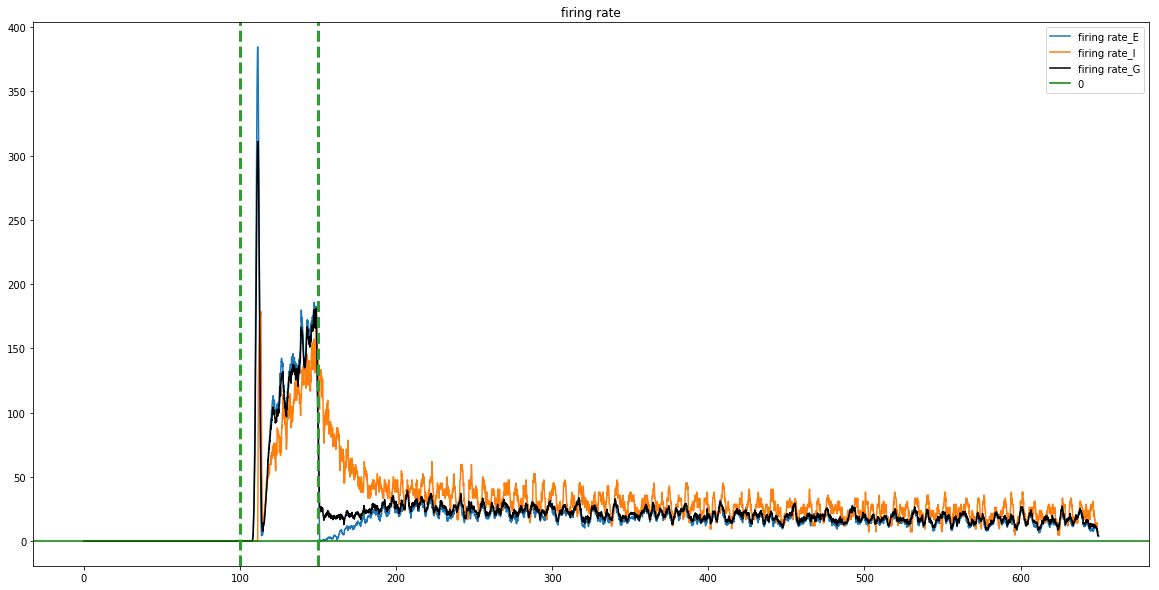

In [8]:
#firing rate
figure(figsize=(20,10))
plot(ratemon_E.t/ms,ratemon_E.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_E")
plot(ratemon_I.t/ms,ratemon_I.smooth_rate(window='flat', width=2*ms)/Hz,label="firing rate_I")
plot(ratemon_G.t/ms,ratemon_G.smooth_rate(window='flat', width=2*ms)/Hz,c="k",label="firing rate_G")
# axhline(y=500,color="r",label="max")
axhline(y=0,color="g",label="0")
axvline(dec_time/ms, ls='--', c='C2', lw=3)
axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)
plt.title("firing rate")
legend()

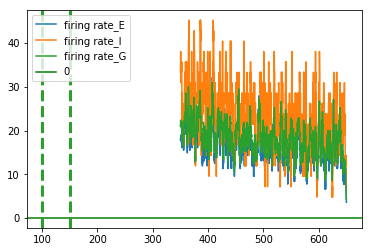

In [9]:
plot(ratemon_E.t[-3000:]/ms,ratemon_E.smooth_rate(window='flat', width=2*ms)[-3000:]/Hz,label="firing rate_E")
plot(ratemon_I.t[-3000:]/ms,ratemon_I.smooth_rate(window='flat', width=2*ms)[-3000:]/Hz,label="firing rate_I")
plot(ratemon_G.t[-3000:]/ms,ratemon_G.smooth_rate(window='flat', width=2*ms)[-3000:]/Hz,label="firing rate_G")

axhline(y=0,color="g",label="0")
axvline(dec_time/ms, ls='--', c='C2', lw=3)
axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)
legend()

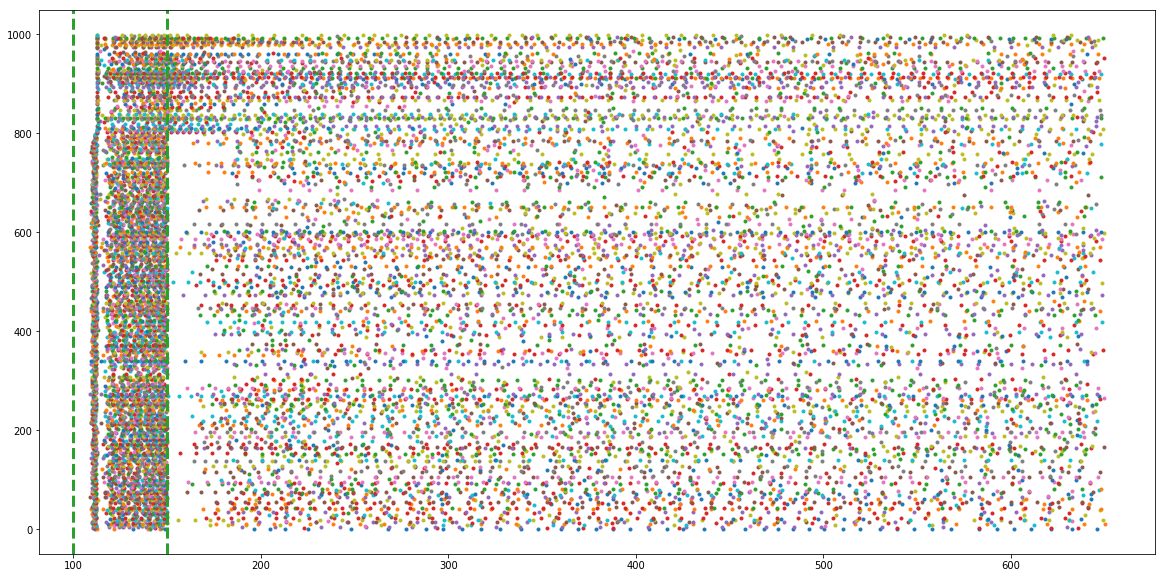

In [10]:
train=spikemon_G.spike_trains()
figure(figsize=(20,10))
for i in range(len(train)):
    plot(train[i]/ms,ones(len(train[i]))*i,'.')

axvline(dec_time/ms, ls='--', c='C2', lw=3)
axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)

# Test

In [11]:
#下面test的neuron的index
s=0

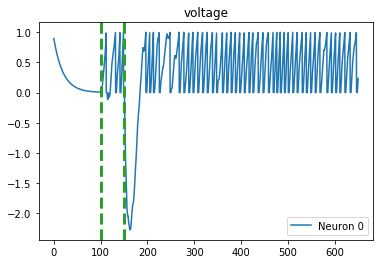

In [12]:
#voltage(主要看neuron0)
figure()
plot(statemon_G.t/ms, statemon_G.v[s], label='Neuron 0')
plt.title("voltage")
axvline(dec_time/ms, ls='--', c='C2', lw=3)
axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)
legend()


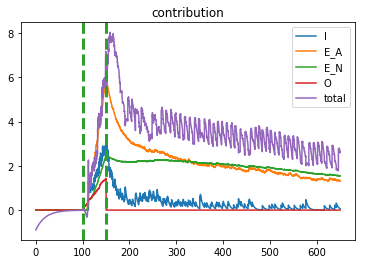

In [13]:
#contribution (the first neuron)
figure()
total=-statemon_G.v[s]+statemon_G_con_E_A.con_E_A[s]+statemon_G_con_E_N.con_E_N[s]-statemon_G_con_I.con_I[s]+statemon_G_con_O.con_O[s]
plot(statemon_G_con_I.t/ms, statemon_G_con_I.con_I[s], label='I')
plot(statemon_G_con_E_A.t/ms, statemon_G_con_E_A.con_E_A[s], label='E_A')
plot(statemon_G_con_E_N.t/ms, statemon_G_con_E_N.con_E_N[s], label='E_N')
plot(statemon_G_con_O.t/ms, statemon_G_con_O.con_O[s], label='O')
plot(statemon_G_con_O.t/ms,total,label="total")
axvline(dec_time/ms, ls='--', c='C2', lw=3)
axvline((dec_time+sti_time)/ms, ls='--', c='C2', lw=3)
plt.title("contribution")
legend()


## remark

*   当strength取15，10的时候，最终会dacay，没有persistent的效果
*   JEO取100（较大），原因可能是总的neuron数目比较少，strength用根号scaling的缘故
*   只要是Balance的条件(JEE=JIE;JEI=JII)且比较大，大多数情况最终都会达到一个比较好看的persistant(水平线形状),有时候(JEE=JIE=50;JEI=JII=250 在进行scaling)时候会有limit cycle(周期形状)
*   将balance条件打破时候JEE=100;JIE=200;JEI=200;JII=100;JEO=100 没有persistant的现象了
*   在上一条的参数下，当运行很长时间以后，发现firing rate是不断增加的，只是比较平缓罢了，也许可以考虑减少JEE,JIE?但是就运行到几百ms是图像还是很好看的。 然而，此时的v回答道-10,是不科学的
*   若stregth太小了，比如10和15，则最终会decay下去